In [1]:
import sys
sys.path.insert(0, '..')
import utils.game_utils as gu

import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


def get_previous_record(year, week, team, all_games_df):
    records = all_games_df[(all_games_df['year'] == year)
                           & (all_games_df['week'] < week) &
                           (all_games_df['team'] == team)]
    if len(records) < 1:
        return None

    return records[-1:]


def get_all_previous_records(year, week, team, all_games_df):
    records = all_games_df[(all_games_df['year'] == year)
                           & (all_games_df['week'] < week) &
                           (all_games_df['team'] == team)]
    if len(records) < 1:
        return None

    return records

def trim_df(df, fields=None):
    if fields is None:
        fields = [
            'team_wins_before',
            'team_losses_before', 'team_ties_before', 'team_wins_after',
            'team_losses_after', 'team_ties_after', 'team_record_total_before',
            'team_record_total_after', 'team_record_normal_before',
            'team_record_normal_after', 'team_opprec_normal_before',
            'team_opprec_normal_after'
        ]
    out_fields = ['year', 'week', 'team_win', 'team']
    out_fields.extend(fields)
    return df[out_fields]


all_games_df = pd.read_csv('../../data/games/all_games_with_data.csv')


In [95]:
def get_df_with_aggregates(index, all_games_df, side='team'):
    SIDE = side # can be opponent
    OTHER_SIDE = 'opponent' if SIDE == 'team' else 'team'
    WEEK_1_TRN = 0.5
    game_df = all_games_df.iloc[index]
    year = game_df['year']
    week = game_df['week']
    team = game_df[SIDE]
    opp_team = game_df[OTHER_SIDE]

    previous_df = get_previous_record(year, week, team, all_games_df)
    opp_previous_df = get_previous_record(year, week, opp_team, all_games_df)

    wins_before = 0
    losses_before = 0
    ties_before = 0

    wins_after = 0
    losses_after = 0
    ties_after = 0

    # todo: still need to handle these (before and after?)
    record_total_before = 0
    record_total_after = 0
    record_normal_before = 0
    record_normal_after = 0
    opp_strength_before = 0
    opp_strength_after = WEEK_1_TRN  # first week everyone is a 50/50 team
    # accumulated normalized records of all opponents
    opprec_normal_before = 0
    opprec_normal_after = 1.0
    opp_trn = WEEK_1_TRN

    ## INFO FROM THIS GAME
    win = bool(game_df[f'{SIDE}_win'])
    tie = game_df['team_score'] == game_df['opponent_score'] # no need for SIDE, just see if both scores are the same
    loss = win == False and tie == False

    def get_val_or(df, field):
        val = df.iloc[0][field]
        if np.isnan(val):
            return 0
        return val
    def get_normalized(x, min, max):
        return (x-min) / (max-min)
    def get_opprec_normal_after(opp_previous_df, record_normal_after):
        if opp_previous_df is None:
            return 1.0

        pre_week = get_val_or(opp_previous_df, 'week')
        pre_opprec_after = get_val_or(opp_previous_df,
                                      f'{SIDE}_opprec_normal_after')
        pre_trn_after = get_val_or(opp_previous_df,
                                   f'{SIDE}_record_normal_after')

        new_opprec = (pre_opprec_after + pre_trn_after) / 2
        final_new_opprec = (new_opprec + record_normal_after) / 2

        return final_new_opprec
    def get_opp_strength_after(opp_previous_df, opp_strength_before):
        '''
        Opponent Strength is essentially the TRN value
        (record_normal) or the wins/losses of a team.
        We want to accumulate the opp_strength from week to
        week to see how strong all opponents have been.
        '''
        if opp_previous_df is None:
            return 1.0

        opp_prev_trn = get_val_or(opp_previous_df, f'{SIDE}_record_normal_after')
        # normalized (/2)
        return (opp_strength_before + opp_prev_trn) / 2


    ## DATA FROM PREVIOUS GAME
    if previous_df is not None:
        try:
            wins_before = get_val_or(previous_df, f'{SIDE}_wins_after')
            losses_before = get_val_or(previous_df, f'{SIDE}_losses_after')
            ties_before = get_val_or(previous_df, f'{SIDE}_ties_after')
            record_total_before = get_val_or(previous_df,
                                              f'{SIDE}_record_total_after')
            record_normal_before = get_val_or(previous_df,
                                              f'{SIDE}_record_normal_after')
            opprec_normal_before = get_val_or(previous_df,
                                              f'{SIDE}_opprec_normal_after')
            opp_strength_before = get_val_or(previous_df,
                                              f'{SIDE}_opp_strength_after')

            wins_after = wins_before
            losses_after = losses_before
            ties_after = ties_before
            record_total_after = record_total_before
            record_normal_after = record_normal_before
            opprec_normal_after = get_opprec_normal_after(
                opp_previous_df, record_normal_after)

            opp_strength_after = get_opp_strength_after(
                opp_previous_df, opp_strength_before)

            opp_trn = get_val_or(opp_previous_df,
                                 f'{SIDE}_record_normal_after')

        except Exception as e:
            print(e)

    ## CALCULATE NEW DATA (after)
    if win:
        wins_after += 1
    if tie:
        ties_after += 1
    if loss:
        losses_after += 1

    ## CALCULATE RECORD NORMAL
    record_total_after = wins_after - losses_after # eg: +2 or -7 etc.
    record_normal_after = get_normalized(record_total_after, week * -1, week)


    # todo: maybe we should be authoring is_tie as well?

    all_games_df.at[index, [
        f'{SIDE}_wins_before',
        f'{SIDE}_wins_after',
        f'{SIDE}_losses_before',
        f'{SIDE}_losses_after',
        f'{SIDE}_ties_before',
        f'{SIDE}_ties_after',
        f'{SIDE}_record_total_before',
        f'{SIDE}_record_total_after',
        f'{SIDE}_record_normal_before',
        f'{SIDE}_record_normal_after',
        f'{SIDE}_opp_strength_before',
        f'{SIDE}_opp_strength_after',
        f'{SIDE}_opprec_normal_before',
        f'{SIDE}_opprec_normal_after',
        f'{SIDE}_opp_trn',
    ]] = [
        int(wins_before), 
        int(wins_after), 
        int(losses_before), 
        int(losses_after), 
        int(ties_before),
        int(ties_after), 
        int(record_total_before), 
        int(record_total_after),
        float(record_normal_before), 
        float(record_normal_after), 
        float(opp_strength_before),
        float(opp_strength_after), 
        float(opprec_normal_before), 
        float(opprec_normal_after), 
        float(opp_trn)
    ]

    return all_games_df.iloc[index]


def get_team_df(team, year, all_df):
    return all_df[(all_df['team'] == team) & (all_df['year'] == year)]
def get_year_df(year, all_df):
    return all_df[all_df['year'] == year]
def get_year_up_to_week_df(year, week, all_df):
    return all_df[(all_df['year'] == year) & (all_df['week'] <= week)]

## - - - - - - - - - - - - - - - - - - - -- - - -- - - - - - - -
## C O N F I G
## - - - - - - - - - - - - - - - - - - - -- - - -- - - - - - - -
YEAR = 2018
UP_TO_WEEK = 16
## ADD NEW COLUMNS TO ALL GAMES AND CREATE NEW ALL_GAMES_PLUS_DF (agp_df)
new_col_df = pd.DataFrame(columns=[
    'team_wins_before', 'team_losses_before', 'team_ties_before',
    'team_record_total_before', 'team_record_normal_before', 'team_wins_after',
    'team_losses_after', 'team_ties_after', 'team_record_total_after',
    'team_record_normal_after', 'team_opp_strength_before',
    'team_opp_strength_after', 'team_opprec_normal_before',
    'team_opprec_normal_after'
])
agp_df = all_games_df.join(new_col_df, how="outer")
year_df = get_year_df(YEAR, agp_df)

for index in year_df.index:
    get_df_with_aggregates(index, agp_df)
show_fields = [
    'opponent',
    'team_wins_after', 'team_losses_after', 'team_ties_after',
    # 'team_record_total_after',
    # 'team_record_normal_before',
    'team_record_normal_after',
    # 'team_opp_strength_before',
    'team_opp_strength_after',
    # 'team_opprec_normal_before',
    # 'team_opprec_normal_after'
    'team_opp_trn',
]
year_df = get_year_df(YEAR, agp_df)

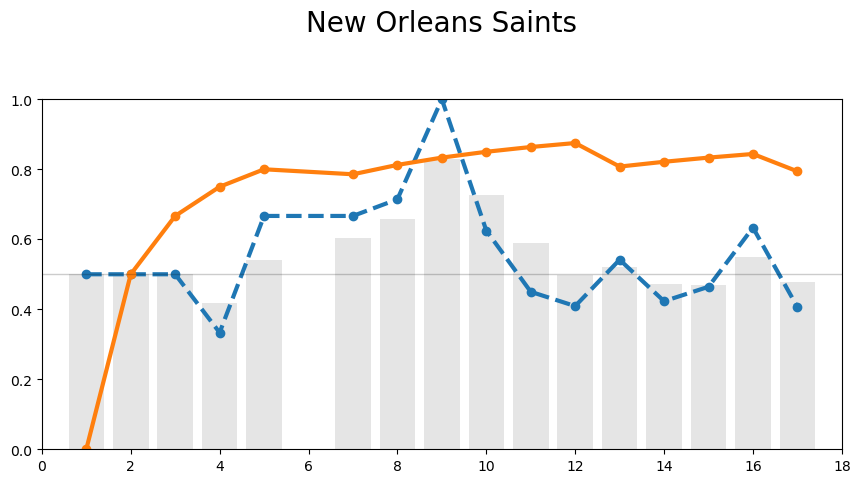

In [96]:
def multi_plot(team_name):
    final_name = team_name
    if ' ' not in team_name:
        final_name = gu.TEAM_NAME[team_name]

    team_df = year_df[year_df['team'] == final_name]
    fig = plt.figure(figsize=(10, 5), dpi=100)
    weeks = team_df['week']
    opp_str = team_df['team_opp_strength_after']
    opp_trn = team_df['team_opp_trn']
    trn = team_df['team_record_normal_after']

    fig.suptitle(final_name, fontsize=20)

    plt.plot(weeks, opp_trn, '--o', lw=3)
    plt.bar(weeks, opp_str, alpha=0.1, color='black')
    plt.plot(weeks, trn, '-o', lw=3)
    plt.ylim(0,1)
    plt.xlim(0,18)
    plt.axhline(y=0.5, lw=1, color='black', alpha=0.2)
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.8)


team_name = 'Saints'
multi_plot(team_name)
# trim_df(year_df[year_df['team'] == gu.TEAM_NAME[team_name]], show_fields)

In [55]:
# names = ['Saints','49ers','Patriots','Chiefs','Steelers']

# for name in names:
#   multi_plot(name)

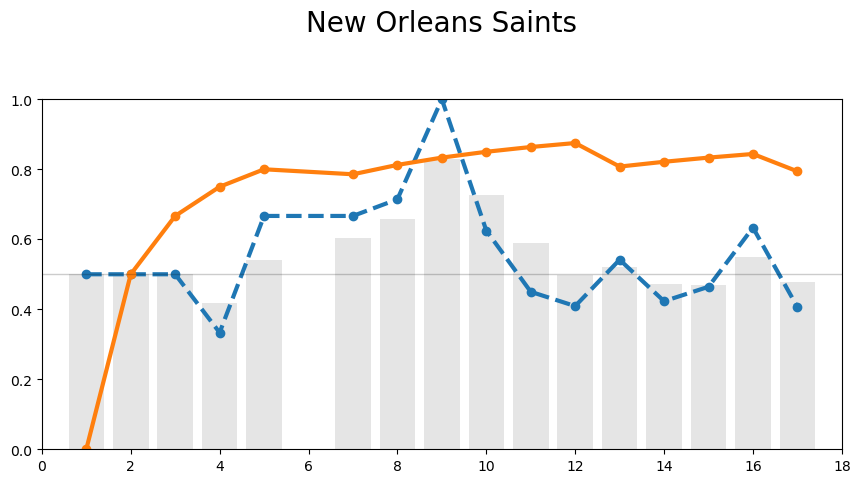

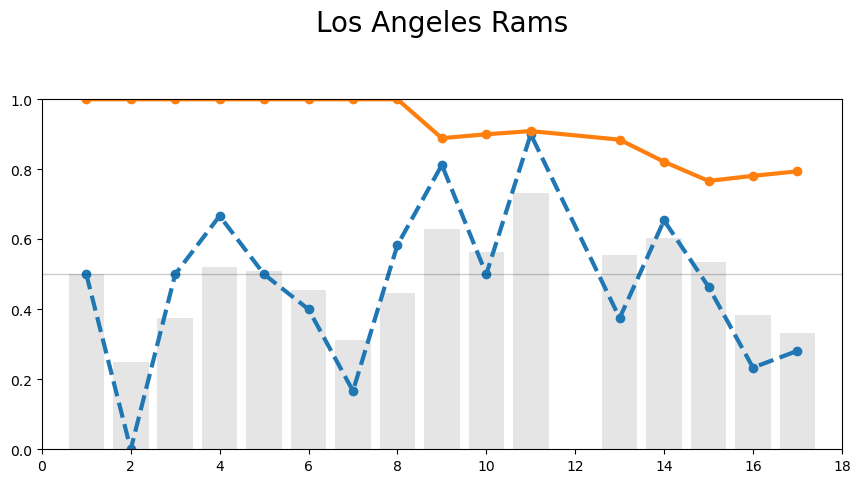

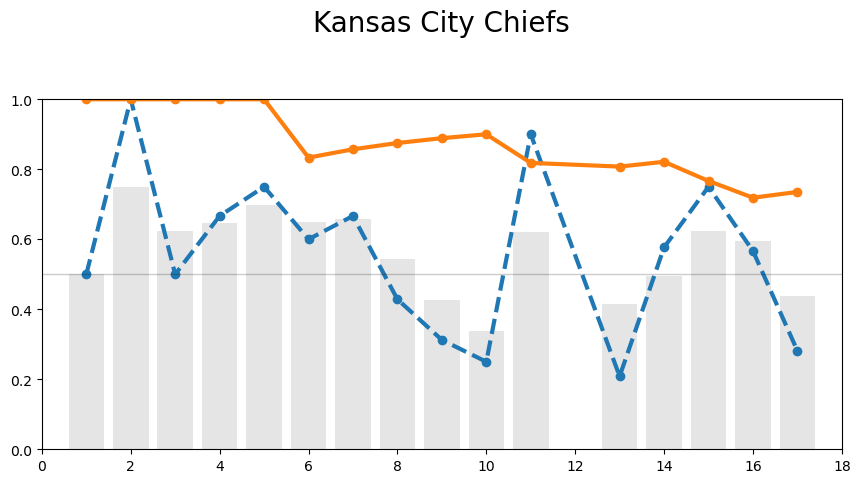

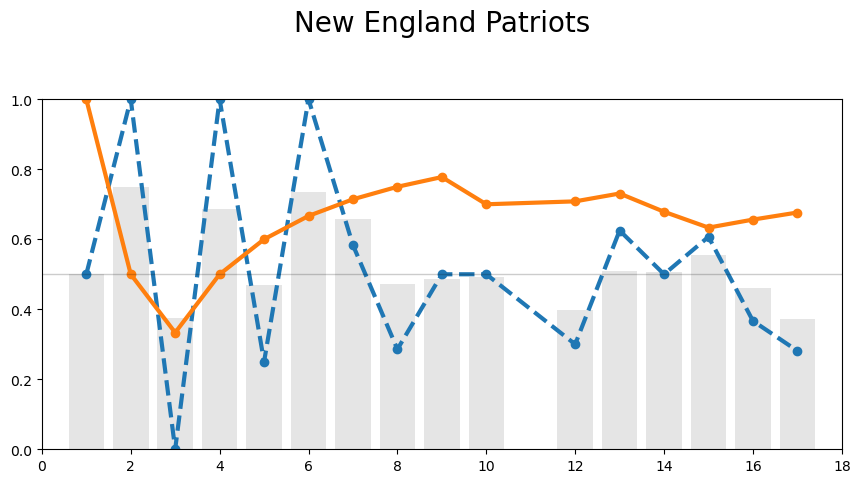

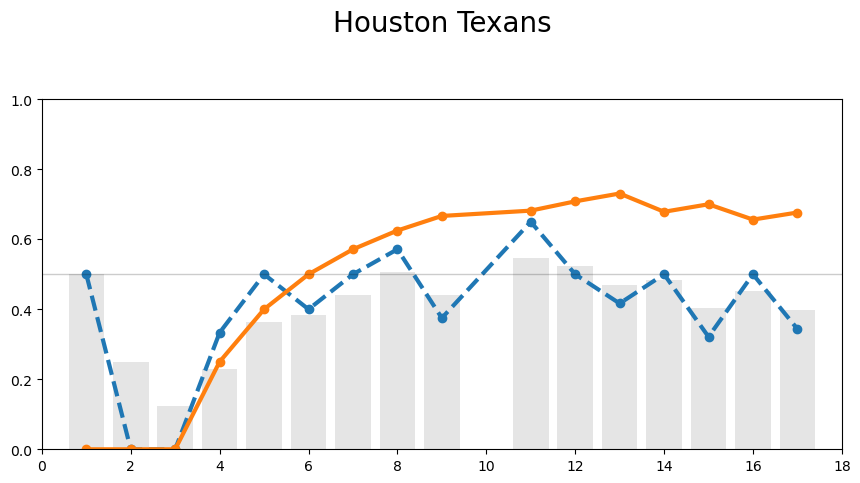

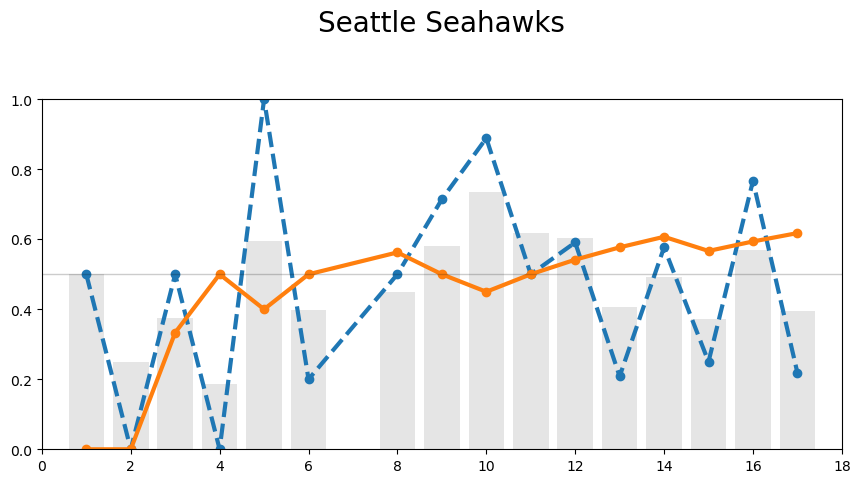

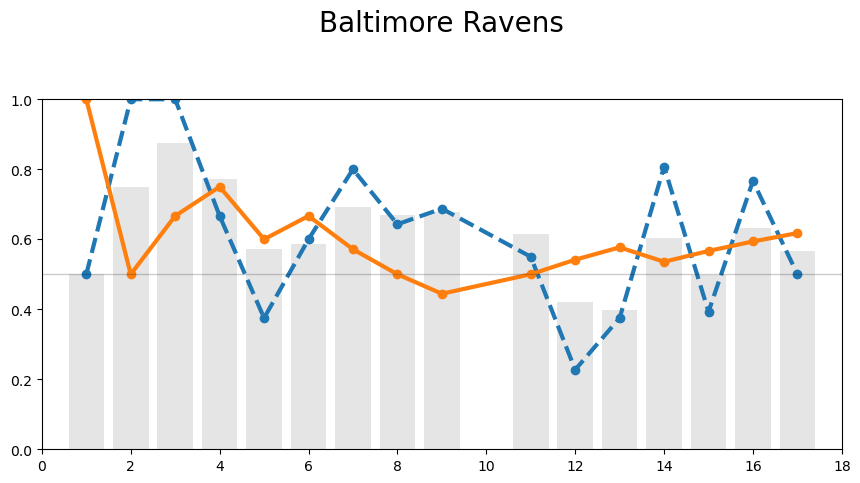

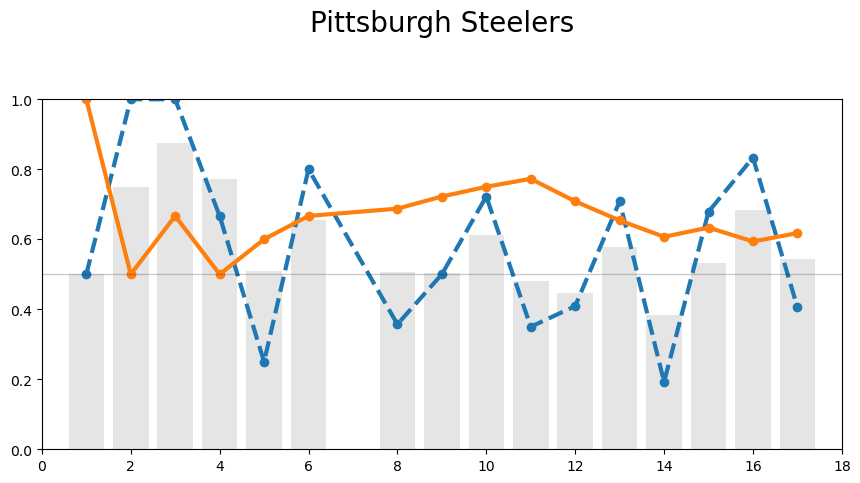

In [97]:
final_df = year_df[(year_df['week'] == 17) & (year_df['home'] == 1)]
best_df = final_df.sort_values('team_wins_after', ascending=False)[:8]
for name in best_df['team'].values:
    multi_plot(name)


In [100]:
tdf = year_df[year_df['team'] == gu.TEAM_NAME['Saints']]

In [101]:
tdf[show_fields].describe()

,team_opp_trn
count,16.000000
mean,0.552103
std,0.162829
min,0.333333
25%,0.443269
50%,0.500000
75%,0.641667
max,1.000000


In [102]:
tdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16 entries, 4106 to 4586
Data columns (total 83 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   date                              16 non-null     object 
 1   year                              16 non-null     int64  
 2   week                              16 non-null     int64  
 3   team                              16 non-null     object 
 4   team_score                        16 non-null     int64  
 5   opponent                          16 non-null     object 
 6   opponent_score                    16 non-null     int64  
 7   win                               16 non-null     int64  
 8   home                              16 non-null     int64  
 9   overtime                          16 non-null     int64  
 10  year_week                         16 non-null     object 
 11  team_win                          16 non-null     int64  
 12  oppon

In [108]:
tdf['team_opp_strength_after']

4106         0.5
4144         0.5
4165         0.5
4217    0.416667
4250    0.541667
4301    0.604167
4335    0.659226
4358    0.829613
4367    0.727307
4412    0.588653
4422    0.498872
4449    0.520269
4487    0.471673
4543    0.467979
4570    0.550656
4586    0.478453
Name: team_opp_strength_after, dtype: object

In [109]:
pd.to_numeric(tdf['team_opp_strength_after'])

4106    0.500000
4144    0.500000
4165    0.500000
4217    0.416667
4250    0.541667
4301    0.604167
4335    0.659226
4358    0.829613
4367    0.727307
4412    0.588653
4422    0.498872
4449    0.520269
4487    0.471673
4543    0.467979
4570    0.550656
4586    0.478453
Name: team_opp_strength_after, dtype: float64